In [1]:
%pip install yfinance pandas numpy scikit-learn tensorflow matplotlib

     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/948.2 kB ? eta -:--:--
     -------------------------------------- 948.2/948.2 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.8-py3-none-any.whl size=139012 sha256=8f9761da1406771f0b8d4e625cc26aa300b8050bcc02b195860c0d9fa4aee3b7
  Stored in directory: c:\users\vipar\appdata\local\pip\cache\wheels\ff\6c\15\506e25bc390de450a7fa53c155cd9b0fbd13ad3e84a9abc183
Successfully built peewee
Note: you may need to restart the kernel to use updated packag

DEPRECATION: Loading egg at c:\python\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [3]:
# Load Bitcoin data from Yahoo Finance
data = yf.download('BTC-USD', start='2015-01-01', end='2024-11-30', progress=False)
data = data[['Close']]  # We are only interested in the 'Close' price
data.head()

Price,Close
Ticker,BTC-USD
Date,
2015-01-01,314.248993
2015-01-02,315.032013
2015-01-03,281.082001
2015-01-04,264.195007
2015-01-05,274.473999


In [9]:
# Normalize the data (feature scaling)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for training (using 60 previous days to predict the next day's price)
def prepare_data(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = prepare_data(scaled_data)

# Reshape X to be compatible with LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

X.shape, y.shape

((3558, 60, 1), (3558,))

In [10]:
# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train.shape, X_test.shape

((2846, 60, 1), (712, 60, 1))

In [11]:
# Build the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Train the LSTM model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
89/89 [==============================] - 6s 30ms/step - loss: 0.0028
Epoch 2/10
89/89 [==============================] - 3s 29ms/step - loss: 8.6883e-04
Epoch 3/10
89/89 [==============================] - 3s 30ms/step - loss: 7.2480e-04
Epoch 4/10
89/89 [==============================] - 3s 29ms/step - loss: 7.0481e-04
Epoch 5/10
89/89 [==============================] - 3s 29ms/step - loss: 5.8102e-04
Epoch 6/10
89/89 [==============================] - 2s 28ms/step - loss: 6.1291e-04
Epoch 7/10
89/89 [==============================] - 3s 28ms/step - loss: 6.0203e-04
Epoch 8/10
89/89 [==============================] - 3s 32ms/step - loss: 5.6642e-04
Epoch 9/10
89/89 [==============================] - 3s 30ms/step - loss: 4.9398e-04
Epoch 10/10
89/89 [==============================] - 3s 29ms/step - loss: 4.6693e-04


23/23 [==============================] - 1s 12ms/step


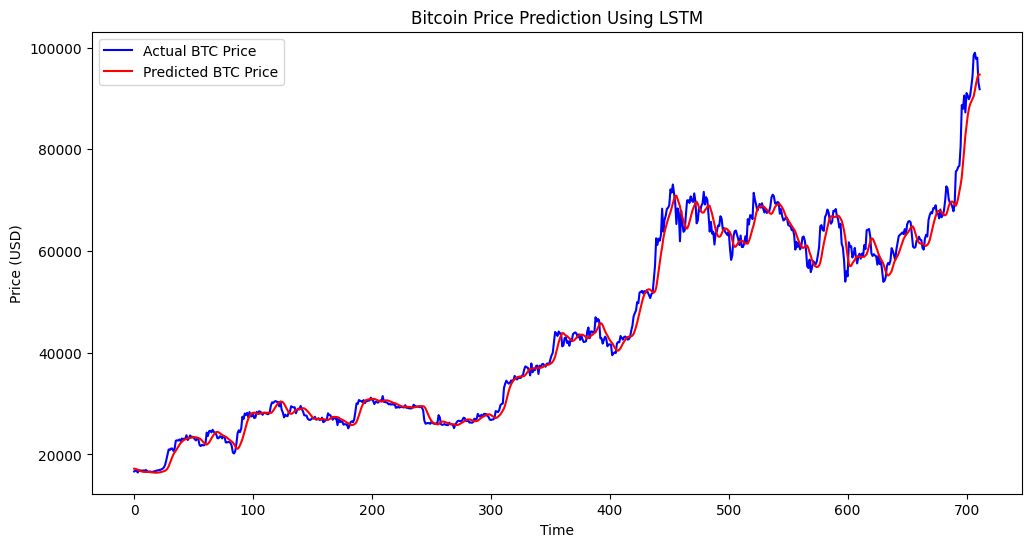

In [13]:
# Predict the prices on the test set
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Convert back to original scale

# Reverse scale the actual values (for comparison)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, color='blue', label='Actual BTC Price')
plt.plot(predicted_prices, color='red', label='Predicted BTC Price')
plt.title('Bitcoin Price Prediction Using LSTM')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [14]:
# Evaluate the model with Mean Squared Error
mse = mean_squared_error(y_test_actual, predicted_prices)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 5064536.646071948


1/1 [==============================] - 0s 24ms/step


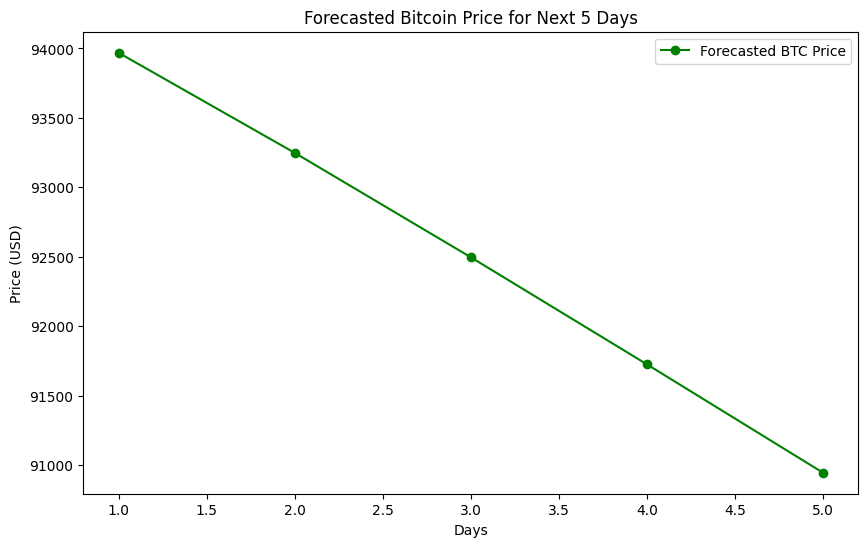

In [15]:
# Forecast future prices
def forecast_future(model, last_data, time_steps=60, forecast_days=5):
    future_predictions = []
    current_input = last_data

    for _ in range(forecast_days):
        prediction = model.predict(current_input.reshape(1, time_steps, 1))
        future_predictions.append(prediction[0, 0])
        current_input = np.append(current_input[1:], prediction)

    return future_predictions

# Get the last 60 days of data for forecasting
last_60_days = scaled_data[-60:]

# Forecast the next 5 days
future_prices = forecast_future(model, last_60_days)
future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

# Plot the forecasted future prices
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 6), future_prices, color='green', marker='o', label='Forecasted BTC Price')
plt.title('Forecasted Bitcoin Price for Next 5 Days')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()